# Calculating filter functions of optimized gates
In this example we want to optimize a Quantum Fourier Transform gate using QuTiP and compute the filter functions for the optimized gate for different initial pulse amplitudes.

For more information on the QuTiP optimization, see the tutorials [here] and, for QFT in particular, [this] notebook.

[here]: https://qutip.org/tutorials.html
[this]: https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/control-pulseoptim-QFT.ipynb

In [1]:
import numpy as np
import qutip as qt
from qutip.control import grape, pulseoptim
from qutip.qip.algorithms import qft

import filter_functions as ff

%matplotlib notebook

We use GRAPE to optimize the pulse for an IQ toy model with $\sigma_{x,i}$ and $\sigma_{y,i}$ as well as an exchange coupling $\sigma_z\otimes\sigma_z$ as controls.

In [2]:
# No constant Hamiltonian
H_d = qt.tensor(qt.sigmaz(), qt.sigmaz())*0.0

H_c = [
    qt.tensor(qt.sigmax(), qt.qeye(2)),
    qt.tensor(qt.sigmay(), qt.qeye(2)),
    qt.tensor(qt.qeye(2), qt.sigmax()),
    qt.tensor(qt.qeye(2), qt.sigmay()),
    qt.tensor(qt.sigmaz(), qt.sigmaz())
]
n_ctrls = len(H_c)
# start point for the gate evolution
U_0 = qt.identity(4)
# Target for the gate evolution - Quantum Fourier Transform gate
U_tar = qft.qft(2)

evo_time = 1
n_ts = 50

# Some optimization parameters
fid_err_targ = 1e-10
max_iter = 10**5
max_wall_time = 10**3
#min_grad = 1e-20

# Initial pulse amplitudes, 'RND'|'LIN'|'ZERO'|'SINE'|'SQUARE'|'TRIANGLE'|'SAW
p_types = ['LIN', 'SINE', 'RND']
results = {
    p_type: pulseoptim.optimize_pulse_unitary(
        H_d, H_c, U_0, U_tar, n_ts, evo_time, fid_err_targ=fid_err_targ,
        max_iter=max_iter, max_wall_time=max_wall_time, 
        out_file_ext=None, alg='GRAPE', init_pulse_type=p_type, gen_stats=True,
        phase_option='PSU',  # ignore global phase
    ) for p_type in p_types
}

We can now easily set up ``PulseSequence`` instances from the final amplitudes and compute the filter functions of each pulse:

<IPython.core.display.Javascript object>


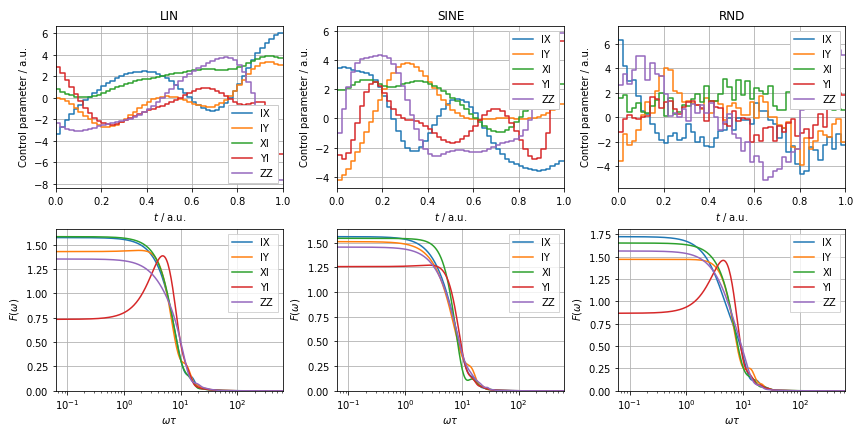

In [3]:
import matplotlib.pyplot as plt
from filter_functions import plotting

identifiers = ['XI', 'YI', 'IX', 'IY', 'ZZ']
pulses = {
    p_type: ff.PulseSequence(
        list(zip(H_c, result.final_amps.T, identifiers)),
        list(zip(H_c, np.ones((n_ctrls, n_ts)), identifiers)),
        [evo_time/n_ts]*n_ts
    ) for p_type, result in results.items()
}

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for i, (p_type, pulse) in enumerate(pulses.items()):
    # Plot the pulse train
    *_, = plotting.plot_pulse_train(pulse, fig=fig, axes=ax[0, i])
    ax[0, i].set_title(p_type)
    # Plot the filter functions
    omega = ff.util.get_sample_frequencies(pulse, spacing='log')
    *_, = plotting.plot_filter_function(pulse, omega, fig=fig, axes=ax[1, i])
    
fig.tight_layout()

Evidently, the pulses with linear and random initial amplitudes filter out DC noise better than those with sinusoidal initial amplitudes, in particular for $\sigma_y$ noise on the first qubit. There, the filter function has DCG-like character to an extent.